In [1]:
# !pip install dask>2.30.0
# !pip install nd2reader
# !pip install pims
# !pip install flowdec
# !pip install aicsimageio==3.3.4


In [2]:
%matplotlib inline
import pims
from pims import ND2_Reader
from ipywidgets import interact
from ipywidgets import widgets
from fnmatch import fnmatch
import numpy as np
import matplotlib.pyplot as plt
from flowdec.nb import utils as nbutils 
from flowdec import data as fd_data
# import pims
# import pims
from flowdec import restoration as fd_restoration
from flowdec import data as fd_data
from flowdec import psf as fd_psf
import dask
import dask.array as da
import tifffile as tf
from nd2reader import ND2Reader
# from pims import ND2_Reader 
# import aicsimageio.vendor.omexml as ome
import glob
import time, sys,os
sys.path.insert(0,'./libraries')
from deco_libraries import update_progress, pimsmeta2OMEXML, Nd2meta2OMEXML, observer, init_RL_algo, deconv, depth_divide
from deco_libraries import SelectFilesButton, tick_choices, get_deltaT

In [3]:
my_button = SelectFilesButton()
my_button # This will display the button in the context of Jupyter Notebook

Button(description='Select Files', icon='square-o', style=ButtonStyle(button_color='orange'))

Button(description='Select Directory', icon='square-o', style=ButtonStyle(button_color='orange'))

In [4]:
if my_button.button.pick:
    filelist = my_button.button.files
elif my_button.button2.pick:
    patterns = ("*.nd2","*.ome.tifNO")
    filelist = [f.path for f in os.scandir(my_button.button2.files) if any(fnmatch(f, p) for p in patterns)]
    filelist.sort()

In [5]:
filelist

['/run/user/1000/gvfs/sftp:host=endovelicus.rush.edu/D:/Stephanie/20211104Ghost/Caru3_1_iGFP5_PLB_VitC_Nuc_Vera_Nh4Cl_1loop.nd2']

In [6]:
#Load the first file for reference and what's inside the file
frames = ND2Reader(filelist[0])
print(frames.sizes)
#Grab metadata
metadata = frames.metadata
print(metadata['channels'])

#If you don't have enough VRAM divide the XY to do the deconvolution that is automatically assembled after
xdivide = round(frames.sizes['x']/1024)
ydivide = round(frames.sizes['y']/1024)
depthdivide = depth_divide(xdivide, ydivide)
frames

{'x': 1024, 'y': 1024, 'c': 3, 't': 138, 'z': 15, 'v': 45}
['mirfp670', 'FITC', 'mRuby3']


<FramesSequenceND>
Axes: 6
Axis 'x' size: 1024
Axis 'y' size: 1024
Axis 'c' size: 3
Axis 't' size: 138
Axis 'z' size: 15
Axis 'v' size: 45
Pixel Datatype: <class 'numpy.float64'>

In [7]:
metadata

{'height': 1024,
 'width': 1024,
 'date': datetime.datetime(2021, 11, 4, 12, 52, 33),
 'fields_of_view': range(0, 45),
 'frames': range(0, 138),
 'z_levels': range(0, 15),
 'z_coordinates': [4695.17,
  4695.67,
  4696.17,
  4696.67,
  4697.17,
  4697.67,
  4698.17,
  4698.67,
  4699.17,
  4699.67,
  4700.17,
  4700.67,
  4701.17,
  4701.67,
  4702.17,
  4698.88,
  4699.38,
  4699.88,
  4700.38,
  4700.88,
  4701.38,
  4701.88,
  4702.38,
  4702.88,
  4703.38,
  4703.88,
  4704.38,
  4704.88,
  4705.38,
  4705.88,
  4701.91,
  4702.41,
  4702.91,
  4703.41,
  4703.91,
  4704.41,
  4704.91,
  4705.41,
  4705.91,
  4706.41,
  4706.91,
  4707.41,
  4707.91,
  4708.41,
  4708.91,
  4706.39,
  4706.89,
  4707.39,
  4707.89,
  4708.39,
  4708.89,
  4709.39,
  4709.89,
  4710.39,
  4710.89,
  4711.39,
  4711.89,
  4712.39,
  4712.89,
  4713.39,
  4710.43,
  4710.93,
  4711.43,
  4711.93,
  4712.43,
  4712.93,
  4713.43,
  4713.93,
  4714.43,
  4714.93,
  4715.43,
  4715.93,
  4716.43,
  4716.9

In [7]:
xdivide

1

Frame([[[ 821., 1390.,  953., ..., 1159.,  971., 1039.],
        [1105., 1024., 1065., ..., 1088., 1005., 1140.],
        [1003.,  783.,  974., ..., 1227., 1320., 1152.],
        ...,
        [1077.,  704., 1051., ..., 1113., 1019., 1432.],
        [1038., 1273.,  898., ...,  945., 1421., 1172.],
        [ 795., 1165.,  882., ..., 1150., 1196.,  904.]],

       [[1098., 1409., 1016., ..., 1169., 1244.,  845.],
        [1460., 1014., 1004., ..., 1057., 1111., 1166.],
        [ 972., 1530., 1172., ...,  871.,  903., 1293.],
        ...,
        [ 916., 1575., 1410., ..., 1167.,  931., 1051.],
        [1031., 1026.,  744., ...,  944.,  817.,  956.],
        [1376.,  947.,  968., ...,  741., 1427., 1143.]],

       [[1103., 1357.,  918., ..., 1099., 1173.,  969.],
        [1405., 1126.,  985., ..., 1152., 1232.,  881.],
        [1051., 1504.,  939., ..., 1041., 1146., 1004.],
        ...,
        [1079., 1406.,  725., ..., 1130.,  998., 1251.],
        [1229., 1230., 1132., ..., 1017., 1063., 1157.],
        [ 964.,  947.,  872., ...,  694., 1259., 1248.]],

       ...,

       [[1067., 1053., 1051., ...,  906.,  866.,  877.],
        [ 881., 1209., 1296., ..., 1001.,  941.,  846.],
        [1170., 1087.,  973., ..., 1284.,  968., 1210.],
        ...,
        [1025., 1565.,  689., ...,  847.,  879., 1036.],
        [1047., 1254.,  779., ...,  900.,  864.,  858.],
        [ 978.,  843., 1028., ..., 1142., 1002.,  962.]],

       [[1162., 1035., 1030., ...,  902., 1071.,  878.],
        [1059., 1081., 1167., ...,  980.,  937.,  843.],
        [1074., 1163., 1104., ..., 1179.,  685., 1000.],
        ...,
        [1173.,  791., 1098., ..., 1159., 1100.,  892.],
        [ 994.,  824.,  962., ...,  864.,  899., 1219.],
        [ 828.,  917., 1050., ..., 1017., 1021., 1090.]],

       [[ 873., 1144.,  964., ..., 1132.,  745.,  943.],
        [1096.,  856.,  769., ...,  862.,  867.,  898.],
        [ 916.,  994., 1044., ..., 1020., 1018., 1113.],
        ...,
        [1038., 1025.,  891., ...,  863.,  773., 1166.],
        [ 890.,  985., 1114., ..., 1495.,  822., 1210.],
        [1447., 1114., 1226., ..., 1050.,  925., 1018.]]])
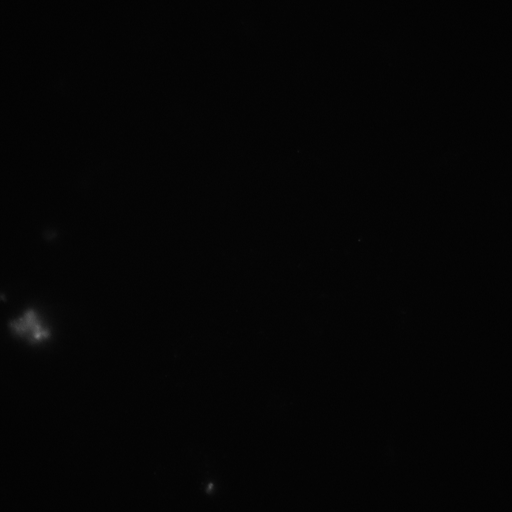
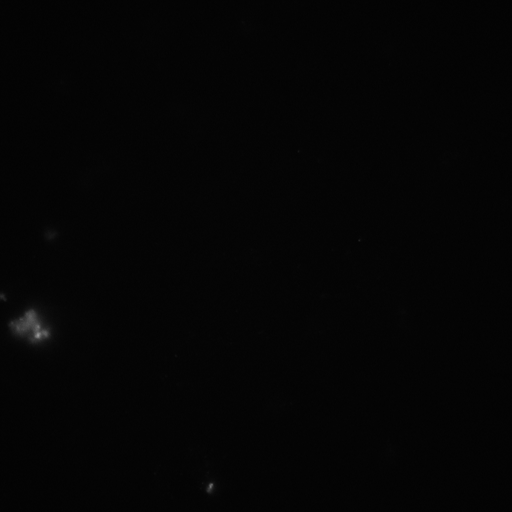
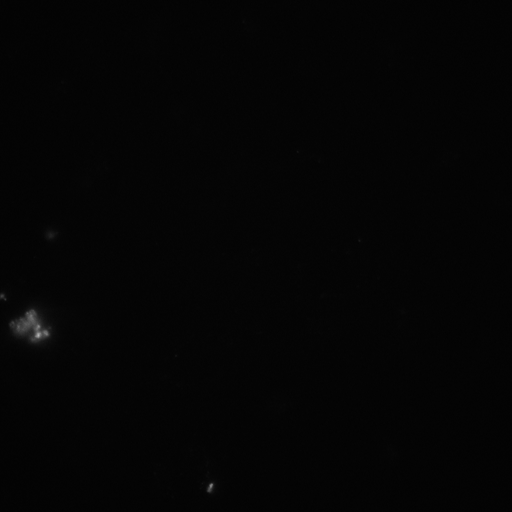
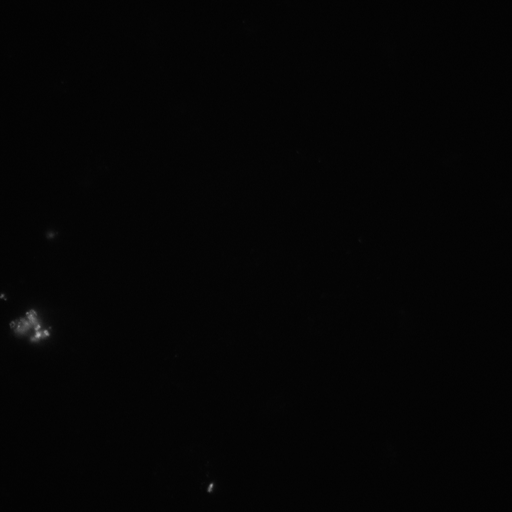
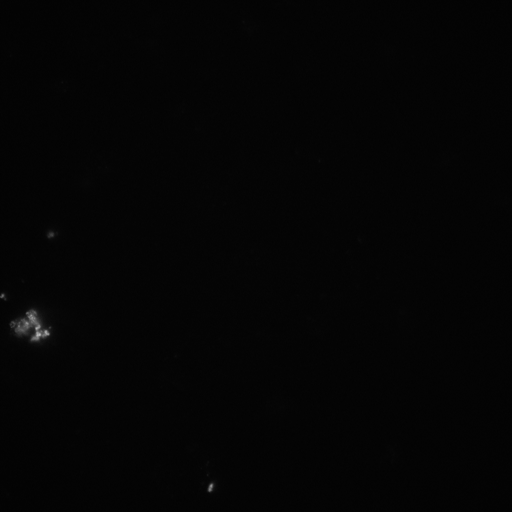
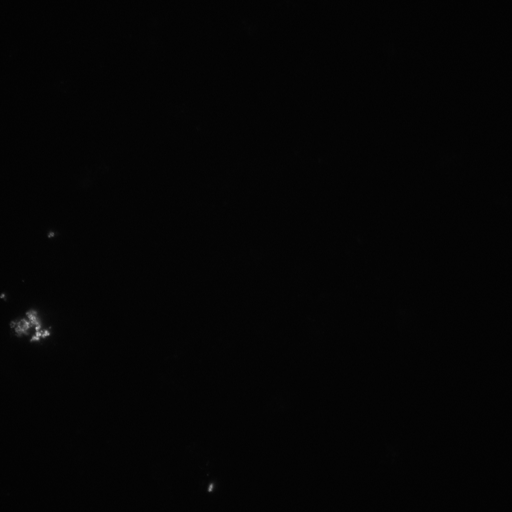
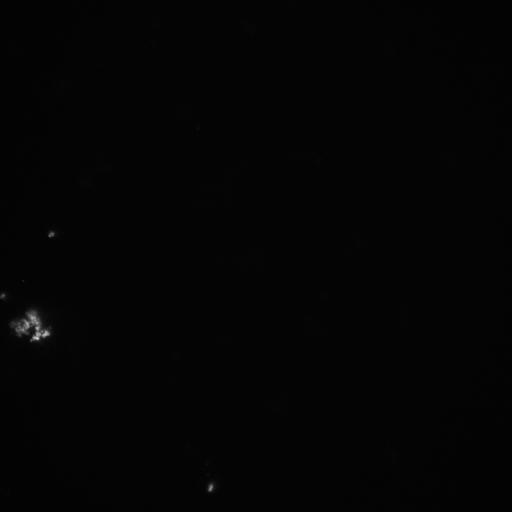
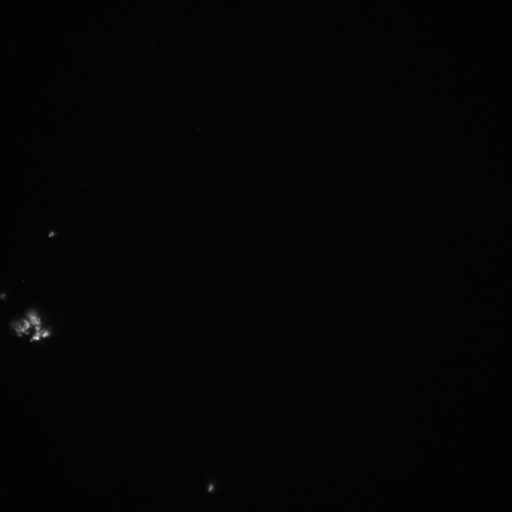
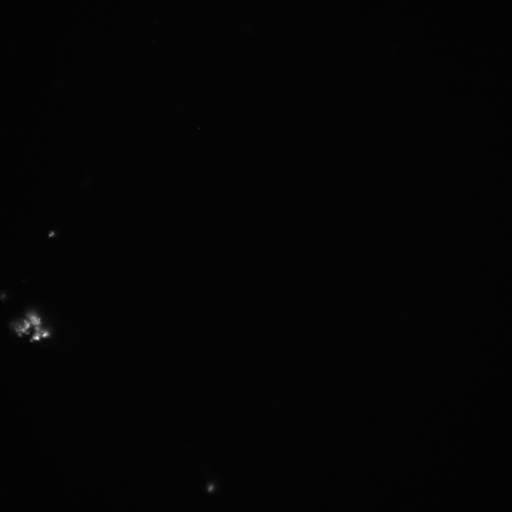
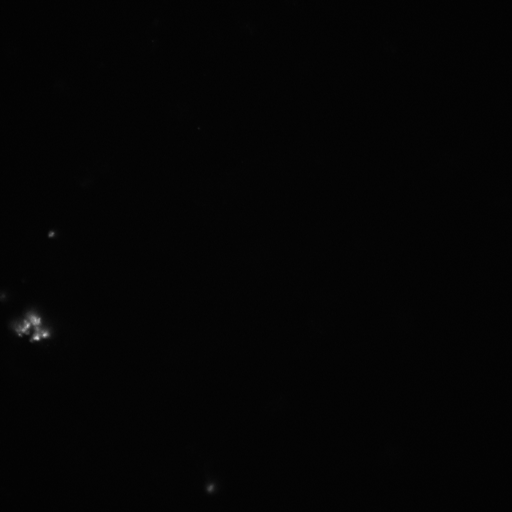
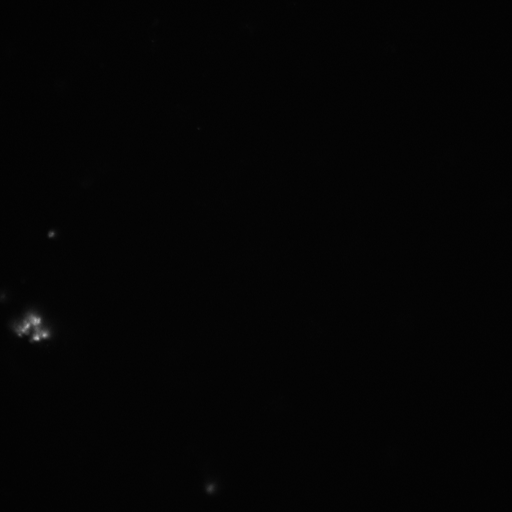
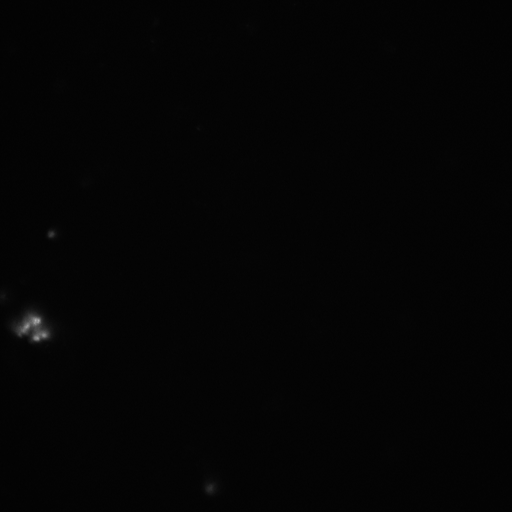
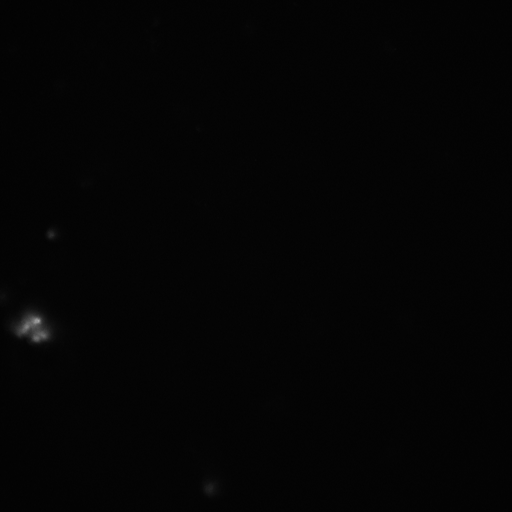
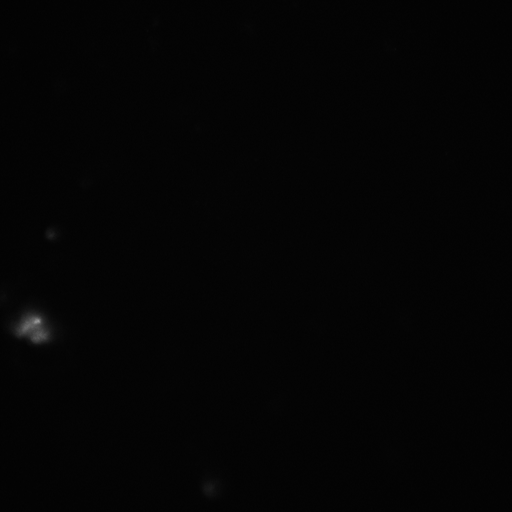
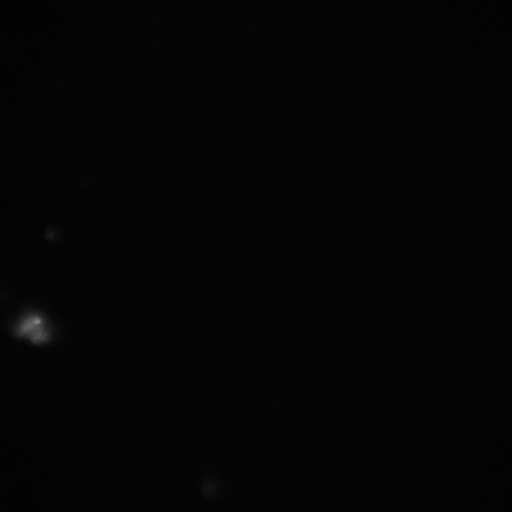

In [8]:
# reader = frames 
frames.iter_axes = 'tc'  # 't' is the default already
frames.bundle_axes = 'zyx'  # when 'z' is available, this will be default
metadata['pixel_microns']
frames[2]

In [9]:
xml = Nd2meta2OMEXML(frames,time_offset=0,maxT=None,verbose=False)
xml.image().Pixels.PhysicalSizeZ

# metadata['channels'][4]

0.5

In [10]:
xml.image().Pixels.PhysicalSizeX



0.21420169761064

In [11]:
#Need to make this a big more automatic, but indexing all the files and iterations is not easy
#In the version where the PSF is estimated by flowdec is easier because everything was set to automatic


# na = meta['NA']
    
    
    
na = 1.4
# na = 0.95
#ra = meta['refractive_index1']
ra = 1.5156
# ra = 1.0
z = int(frames.sizes['z'])
# z= 13
# z = 6
#     x = frames.sizes['x'] // 2
#     y = frames.sizes['y'] // 2
#     z = 26
x = 65
y = 65
res_z = xml.image().Pixels.PhysicalSizeZ
# res_z = xml.image().Pixels.PhysicalSizeZ
res_xy =  metadata['pixel_microns']
distance_cover = 0
work_distance = 250
##Make better with automatic wavelength from metadata and a loop and a dictionary with the PSFs
psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.670 , size_z=  z, size_x=  x , size_y=  y
    ,m = 60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra, ti0 = work_distance
    ,res_lateral =  res_xy , res_axial = res_z, 
    pz = distance_cover 
)
psf647 = psf.generate()    

psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.620 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra,ti0 = work_distance
    ,res_lateral =  res_xy , res_axial = res_z, 
    pz = distance_cover 
)
psfruby = psf.generate()

psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.535 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra, ti0 = work_distance
    ,res_lateral =  res_xy , res_axial = res_z, 
    pz = distance_cover 
)
psfgfp = psf.generate()

psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.420 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra, ti0 = work_distance
    ,res_lateral =  res_xy , res_axial = res_z, 
    pz = distance_cover 
)
psfdapi = psf.generate()  

#Clip Top and bottom, I found that if the PSF is calculated with distance from coverslip, it is flipped from Fiji
#As in, it is Top to Bottom, I acquire the images Bottom to Top
# remove = 13
# remove = 14
# psf647 = np.flip(psf647,
# #                  axis=0
#                 )[remove:-remove]

# psfgfp = np.flip(psfgfp,
# #                  axis=0
#                 )[remove:-remove]
# psfdapi = np.flip(psfdapi,
# #                   axis=0
#                  )[remove:-remove]
# psfruby = np.flip(psfruby,
# #                   axis=0
#                  )[remove:-remove]

print(psf647.shape)
print(psfruby.shape)
# "C:/Users/Mamede/PSF/"

(15, 65, 65)
(15, 65, 65)


In [10]:
#Need to make this a big more automatic, but indexing all the files and iterations is not easy
#In the version where the PSF is estimated by flowdec is easier because everything was set to automatic

PSFdir="/home/jmamede/Rush/PSF/"
psf647 = tf.imread(PSFdir+"/AF647_0.3_EMCCD.tif")
psfruby =  tf.imread(PSFdir+'/mRuby3_0.3_EMCCD.tif')
psfgfp =  tf.imread(PSFdir+'/green_0.3_EMCCD.tif')
psfdapi =  tf.imread(PSFdir+'/DAPI_0.3_EMCCD.tif')
# psf647 = tf.imread(PSFdir+"/AF647_0.5_EMCCD.tif")
# psfruby =  tf.imread(PSFdir+'/mRuby3_0.5_EMCCD.tif')
# psfgfp =  tf.imread(PSFdir+'/green_0.5_EMCCD.tif')
# psfdapi =  tf.imread(PSFdir+'/DAPI_0.5_EMCCD.tif')
# psf647 = tf.imread(PSFdir+"/AF647_0.5.tiff")
# psfruby =  tf.imread(PSFdir+'/mRuby3_0.5.tiff')
# psfgfp =  tf.imread(PSFdir+'/green_0.5.tiff')
# psfdapi =  tf.imread(PSFdir+'/DAPI.tif')
# psf647 = tf.imread(PSFdir+"/AF647_0.3.tif")
# psfruby =  tf.imread(PSFdir+'/mRuby3_0.3.tif')
# psfgfp =  tf.imread(PSFdir+'/green_0.3.tif')
# psfdapi =  tf.imread(PSFdir+'/DAPI_0.3.tif')
# psfruby = psf647
# psfgfp = psf647
# psfdapi = psf647

#Clip Top and bottom, I found that if the PSF is calculated with distance from coverslip, it is flipped from Fiji
# As in, it is Top to Bottom, I acquire the images Bottom to Top
remove = 5
# # remove = 14
# # [remove:-remove,111:-110,111:-110]
removeXY = 1
psf647 = np.flip(psf647,
#                  axis=0
               )[remove:-remove,removeXY+1:-removeXY,removeXY+1:-removeXY]

psfgfp = np.flip(psfgfp,
#                  axis=0
                )[remove:-remove,removeXY+1:-removeXY,removeXY+1:-removeXY]
psfdapi = np.flip(psfdapi,
#                   axis=0
                 )[remove:-remove,removeXY+1:-removeXY,removeXY+1:-removeXY]
psfruby = np.flip(psfruby,
#                   axis=0
                 )[remove:-remove,removeXY+1:-removeXY,removeXY+1:-removeXY]

print(psf647.shape)

# print(psfruby.shape)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(25, 125, 125)


In [97]:
step = np.round(xml.image().Pixels.PhysicalSizeZ/0.1).astype(np.int)
#if camera from metadata == cMOS:
#else if camerafrommetada == EMCCD:
# psf = tf.imread('C:/Users/Mamede/PSF/Cy5_cMOS_0p1.tiff')[::step,...]
# psfdapi = tf.imread('C:/Users/Mamede/PSF/fitc_emccd_averaged_0p1.tiff')[::step,...]
# psfruby = tf.imread('C:/Users/Mamede/PSF/red_emccd_averaged_0p1.tiff')[::step,...]
# psfgfp = tf.imread('C:/Users/Mamede/PSF/fitc_emccd__emccd_averaged_0p1.tiff')[::step,...]

psf647 = tf.imread('C:/Users/Mamede/PSF/Cy5_emccd_averaged_0p1.tiff')[::step,...]
psfdapi = tf.imread('C:/Users/Mamede/PSF/fitc_emccd_averaged_0p1.tiff')[::step,...]
psfruby = tf.imread('C:/Users/Mamede/PSF/red_emccd_averaged_0p1.tiff')[::step,...]
psfgfp = tf.imread('C:/Users/Mamede/PSF/fitc_emccd_averaged_0p1.tiff')[::step,...]

# psfdapi = psf
# psfgfp = psf
# psfruby = psf
# psf647 = psf
print(psfdapi.shape)

C:\Users\Mamede\anaconda3\envs\flowdec\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


(13, 31, 31)


Frame([[[3.04880844e-06, 3.40860308e-06, 3.42581936e-06, ...,
         3.42581936e-06, 3.40860308e-06, 3.04880844e-06],
        [3.40860308e-06, 3.38649101e-06, 4.56763550e-06, ...,
         4.56763550e-06, 3.38649101e-06, 3.40860308e-06],
        [3.42581936e-06, 4.56763550e-06, 3.14205165e-06, ...,
         3.14205165e-06, 4.56763550e-06, 3.42581936e-06],
        ...,
        [3.42581936e-06, 4.56763550e-06, 3.14205165e-06, ...,
         3.14205165e-06, 4.56763550e-06, 3.42581936e-06],
        [3.40860308e-06, 3.38649101e-06, 4.56763550e-06, ...,
         4.56763550e-06, 3.38649101e-06, 3.40860308e-06],
        [3.04880844e-06, 3.40860308e-06, 3.42581936e-06, ...,
         3.42581936e-06, 3.40860308e-06, 3.04880844e-06]],

       [[2.08468077e-06, 2.38186917e-06, 2.22386090e-06, ...,
         2.22386090e-06, 2.38186917e-06, 2.08468077e-06],
        [2.38186917e-06, 2.19382359e-06, 3.11263487e-06, ...,
         3.11263487e-06, 2.19382359e-06, 2.38186917e-06],
        [2.22386090e-06, 3.11263487e-06, 1.81441100e-06, ...,
         1.81441100e-06, 3.11263487e-06, 2.22386090e-06],
        ...,
        [2.22386090e-06, 3.11263487e-06, 1.81441100e-06, ...,
         1.81441100e-06, 3.11263487e-06, 2.22386090e-06],
        [2.38186917e-06, 2.19382359e-06, 3.11263487e-06, ...,
         3.11263487e-06, 2.19382359e-06, 2.38186917e-06],
        [2.08468077e-06, 2.38186917e-06, 2.22386090e-06, ...,
         2.22386090e-06, 2.38186917e-06, 2.08468077e-06]],

       [[1.52805538e-06, 1.78390089e-06, 1.55087085e-06, ...,
         1.55087085e-06, 1.78390089e-06, 1.52805538e-06],
        [1.78390089e-06, 1.52642152e-06, 2.28570112e-06, ...,
         2.28570112e-06, 1.52642152e-06, 1.78390089e-06],
        [1.55087085e-06, 2.28570112e-06, 1.10474545e-06, ...,
         1.10474545e-06, 2.28570112e-06, 1.55087085e-06],
        ...,
        [1.55087085e-06, 2.28570112e-06, 1.10474545e-06, ...,
         1.10474545e-06, 2.28570112e-06, 1.55087085e-06],
        [1.78390089e-06, 1.52642152e-06, 2.28570112e-06, ...,
         2.28570112e-06, 1.52642152e-06, 1.78390089e-06],
        [1.52805538e-06, 1.78390089e-06, 1.55087085e-06, ...,
         1.55087085e-06, 1.78390089e-06, 1.52805538e-06]],

       ...,

       [[1.52805538e-06, 1.78390089e-06, 1.55087085e-06, ...,
         1.55087085e-06, 1.78390089e-06, 1.52805538e-06],
        [1.78390089e-06, 1.52642152e-06, 2.28570112e-06, ...,
         2.28570112e-06, 1.52642152e-06, 1.78390089e-06],
        [1.55087085e-06, 2.28570112e-06, 1.10474545e-06, ...,
         1.10474545e-06, 2.28570112e-06, 1.55087085e-06],
        ...,
        [1.55087085e-06, 2.28570112e-06, 1.10474545e-06, ...,
         1.10474545e-06, 2.28570112e-06, 1.55087085e-06],
        [1.78390089e-06, 1.52642152e-06, 2.28570112e-06, ...,
         2.28570112e-06, 1.52642152e-06, 1.78390089e-06],
        [1.52805538e-06, 1.78390089e-06, 1.55087085e-06, ...,
         1.55087085e-06, 1.78390089e-06, 1.52805538e-06]],

       [[2.08468077e-06, 2.38186917e-06, 2.22386090e-06, ...,
         2.22386090e-06, 2.38186917e-06, 2.08468077e-06],
        [2.38186917e-06, 2.19382359e-06, 3.11263487e-06, ...,
         3.11263487e-06, 2.19382359e-06, 2.38186917e-06],
        [2.22386090e-06, 3.11263487e-06, 1.81441101e-06, ...,
         1.81441101e-06, 3.11263487e-06, 2.22386090e-06],
        ...,
        [2.22386090e-06, 3.11263487e-06, 1.81441101e-06, ...,
         1.81441101e-06, 3.11263487e-06, 2.22386090e-06],
        [2.38186917e-06, 2.19382359e-06, 3.11263487e-06, ...,
         3.11263487e-06, 2.19382359e-06, 2.38186917e-06],
        [2.08468077e-06, 2.38186917e-06, 2.22386090e-06, ...,
         2.22386090e-06, 2.38186917e-06, 2.08468077e-06]],

       [[3.04880844e-06, 3.40860308e-06, 3.42581936e-06, ...,
         3.42581936e-06, 3.40860308e-06, 3.04880844e-06],
        [3.40860308e-06, 3.38649101e-06, 4.56763550e-06, ...,
         4.56763550e-06, 3.38649101e-06, 3.40860308e-06],
        [3.42581936e-06, 4.56763550e-06, 3.14205165e-06, ...,
         3
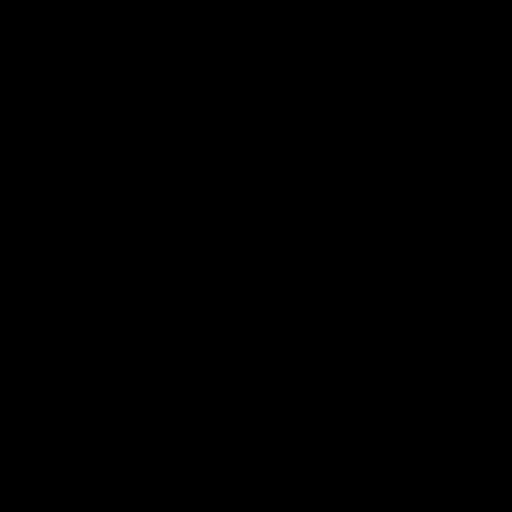
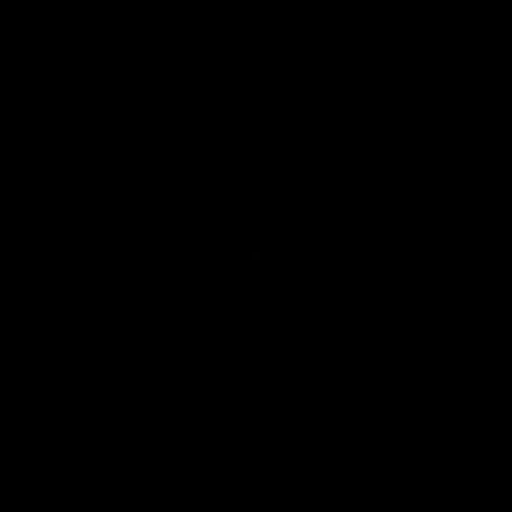
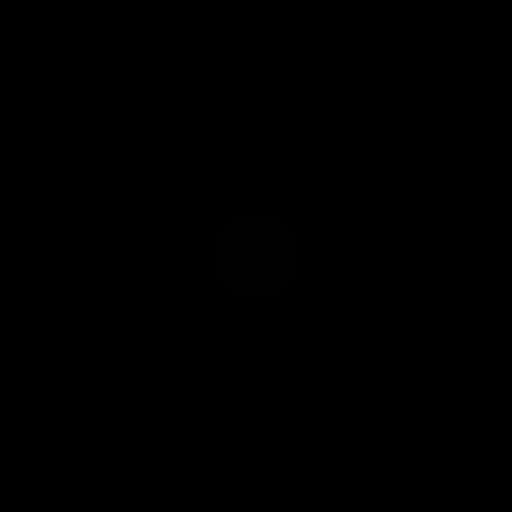
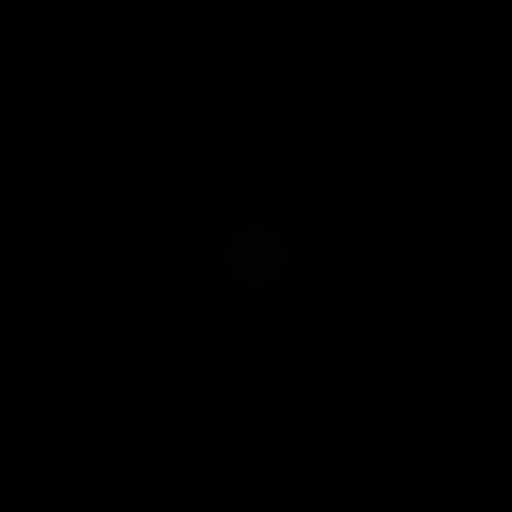
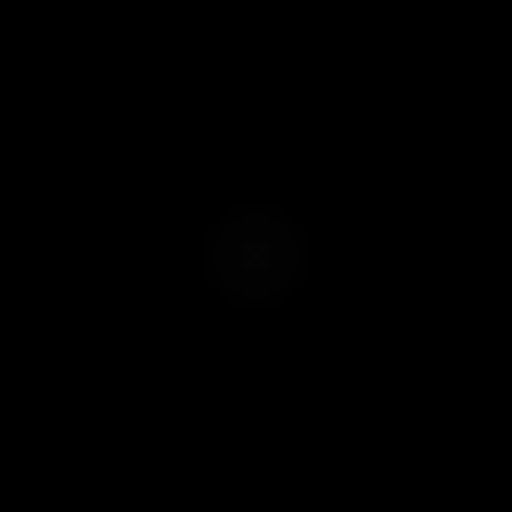
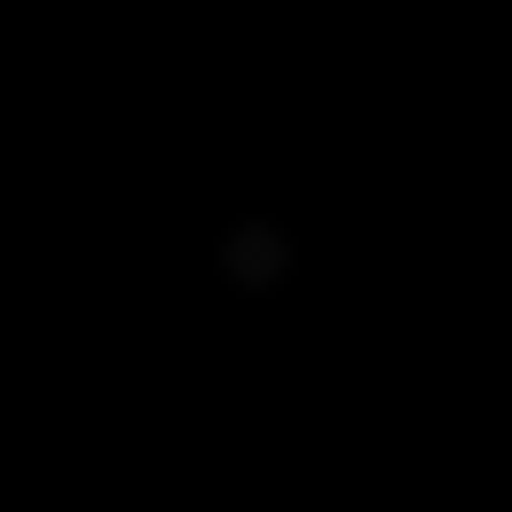
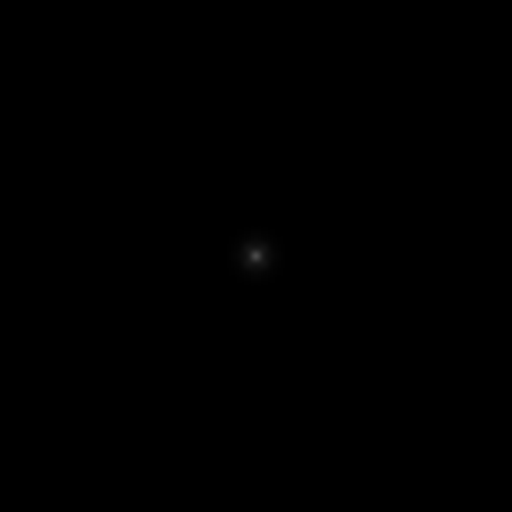
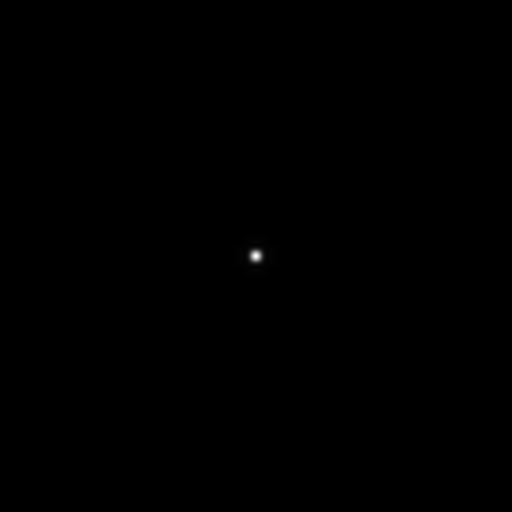
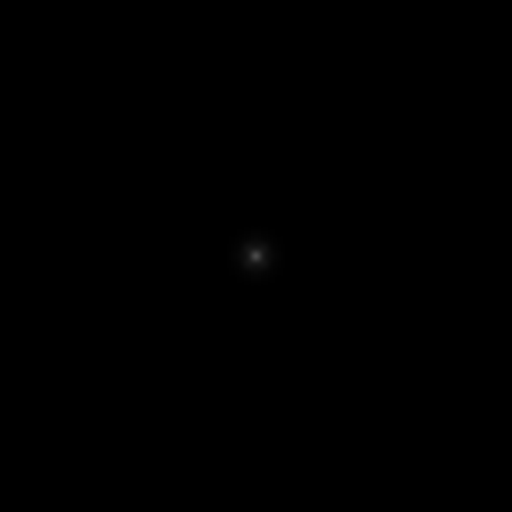
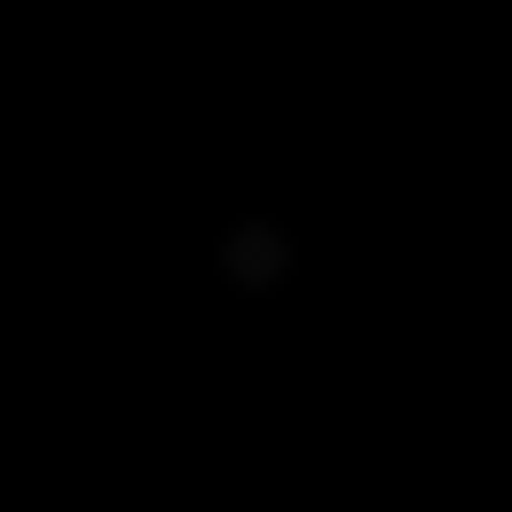
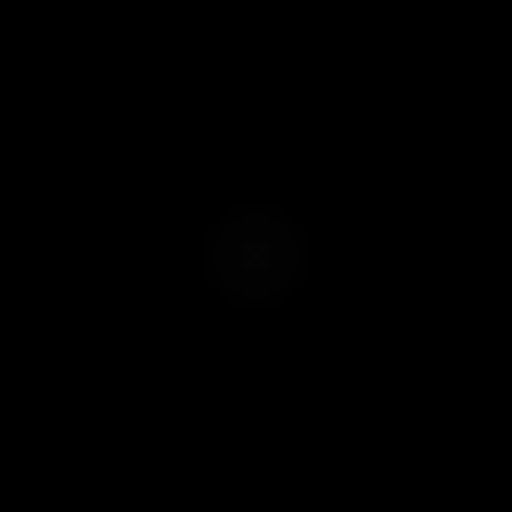
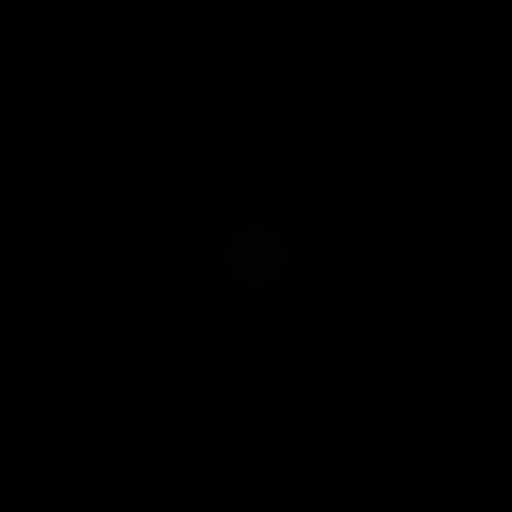
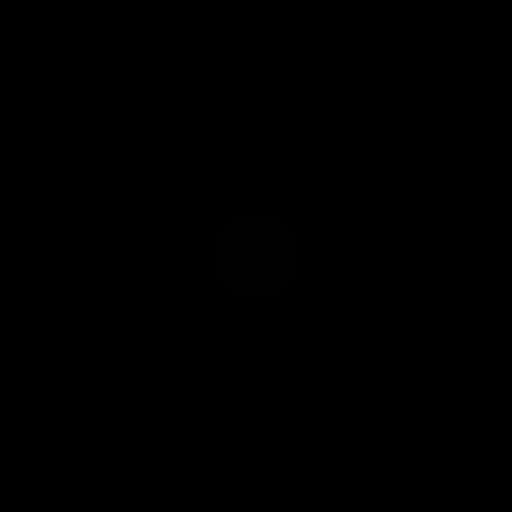
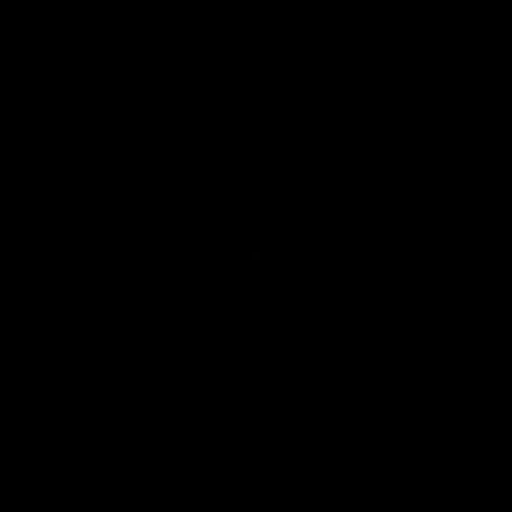
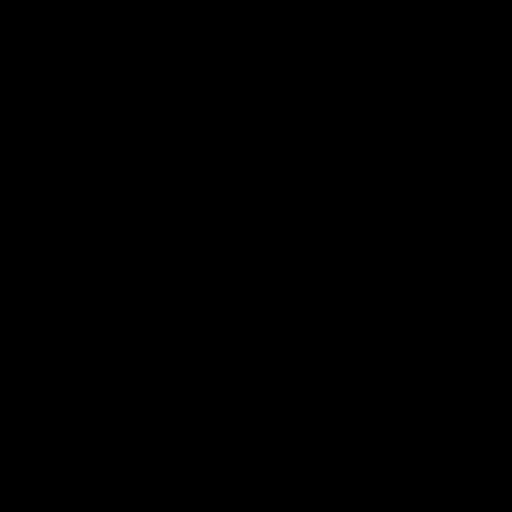

In [12]:
import pims
pims.Frame(psf647)

In [12]:
algo = init_RL_algo(psfgfp.ndim
#                    ,pad_mode='2357'
#                    ,pad_min=(2,24,24)
                   ,pad_mode='log2'
#                     ,pad_min=(2,24,24)
#                       ,pad_mode='none'
                  )
# from flowdec import restoration as fd_restoration
# algo = fd_restoration.RichardsonLucyDeconvolver(n_dims=psfgfp.ndim
#                                                     # , pad_mode=pad_mode
#                                                     # ,pad_min=pad_min
#     #                                                     ,observer_fn=observer
#                                                     #,real_domain_fft=True
#                                                     #,device='/cpu:0'
#                                                    ).initialize()
# data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAAAAADRE4smAAAWkUlEQVR4nO2d2ZbiOgxFJVb//yejfvAkDzGEBMrW0b59q4oAYfCOPMhOmE7AX3rsn3DbG5SP7/wR0/fw+NW7cNbEBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDn37d2XKegLqTeprms5XOOyzP/Bm/7fpcX4DfJ4SWywzVeBYDjAoDjAoDjAoDjAoDjAoDjAoDjAoDjAoDjAoDjAoDjAoDjAoDztXSwM6JOOq6QG/yaAOslap0RXgWA4wKA4wKA4wKA4wKA4wKA4wKA4wKA4wKA4wKA4wKA4wKA4wKA0+baUJN4P3q7ZxLAv0kWewQAxwUAxwUAxwUAxwUAxwUAxwUAxwUAxwUAxwUAxwUAxwUAxwUA599mWTvnZjZfHWxZ39+sJPYqABwXABwXABwXABwXABwXABwXABwXABwXABwXABwXABwXABwXABz+k9Wg08e2ea8FMn6n3u/7XMjw3ZYc/NfsaYFv2/klXgWA4wKA4wKA4wKA4wKA4wKA4wKA4wKA4wKA4wKA4wKA4wKA4wKA86PFobfliu976jSh+vn7XeFysGfwCACOCwCOCwCOCwCOCwCOCwCOCwCOCwCOCwCOCwCOCwCOCwCOCwDOqWzgegsH18vEzb+j+h3y7M4fsfm5gmtOCbqezX+CVwHguADguADguADguADguADguADguADguADguADguADguADgmBLgvvPe4jD/ynh688KOb4MPb7xKr37p/L9zpvu97UXP7OhUOniz8wp/a5nxCtMObsNUFeCcxwUAxwUAxwUAxwUAxwUAxwUAxwUAxwUAxwUAxwUAxwUA5z4Bpusef4SpNM1vuLI49E++7plZ02zllXc73dOZzOGZHf3m6zW1OnjKfTFp9TT4KbwNAI4LAI4LAI4LAI4LAI4LAI4LAI4LAI4LAI6PBL7Dl87vyAvkLmxFAFODtL8BJwIswXqntp0LcCbvNQ2MX1tWypOvkbu38RUurCOsnto+9HNZztRRBiJA+bhS/a3vvOjBhQN39VrpWwL8+VwBPrznp6xe/sYagX/Bj651/S0MVAGK2Tc6bxFcOM3/3tgS4BWmiu4evAoAxwUAxwUAxwUAxxuBgRVGZf8EEAFeN/+/dGK4FRJ+U8wKwNUveuXAmXtXL9NTeBvglyw4DvG1XMDvPmt4JSH6VcA9tcDv4+/hR5XHjQLM3vBXTjLbnSdYzn1r+vkXvu3PP8w8ATx96Bmmwt4nwAI1Ix/OD+haBAvyN2/OYBuA+e7Txm+e8JtitBfA+ce1XQz+XiLW3YdRAUrQF7VhUnLLH6nfwqwACdY/fSSww2AbwDmDCwCOCwAORhtAQguQj1vzyydtvoVBAXSzT93oG4DVSKC6AeWCKQH4niNZJRfsY64NMBsF/Epnf/MRBFMRoJBGAqVqA0xG9FZoA/zJe9juwpH8yTLJcRvg7Z1UplypHKbP/JtQsmAEeJUkfXU920EjcP5QomEjkEePmz+Tunf/eZHPVyNdmKRW31xQgM84FxniUz67d/Nav8aMAGk2QP67SgkO5wOs1gb4E0z1AvjF0fn2oXtmSsHm8cBQBAjwhYN587L8CHMCUAkEXRWAWMCvMFUFOOdxAcCxWAUoWIiJhA+qANSmv8KiALoNwNNBwNEdYFJYEYDLv4tNvXQuIZCRgd0FqIZ+DscBqn5BQGaDh0x6iFe6530aJxaUancBiOjFqG0/Hpj+TgUbj/e5D1YxIcCIwUF/FAFuWEWyL3MBmm/lTAA7c4b1M19+icdtPOW0QJhJuHv5SZTQa0fCC7z9Qft5Bn3qWN+53hKjUxFgsaOEVWMtNAG4+overAIO9j4unr7Iub1/envCn/iwdxUwCd7VYTxvBKrW3nhXf7J2/EfsLcAUntbtTSPwN3gv4HbKiA+NCpvr/uE73UCOYnyjG7gguwuQ4Opf2wh84/m5Yk+NQLWL5eP4BawIUMPE2ohxn7B9iqHD+gSeDQQHQgDLIfwqXgUE5INZxSawIwCH4Z9S6uoulld1POemvmoE5sTg/Llbs7cA4eiWUaGHu5uRwHZEetRZyP3JKtGYb6nFZpT12NiOfQXgwV9qizbiKAKwhA7/rPza4uXq1/DVt2JfAcawyg0cR4C6SDc+fq+zlwCxrFIZy/D449TyqyQYpYXTsc+xEXhZhSZTJBvUD/9ui2BndnTqRXUOlUe/0o3qgGcZFH4TAd6pAtLTPssNth/lxJ3tjuTwxiX2igDvoxLCw34BEVVFz1XjXzk3jjJ2sCYAq6LnwwhQPyWUPcssq2SWfQUohSVd9odLey8ZMSrTVAXk3b2xmr/rBm4+SLCvAAWuDvyymZma2P/OOMDxi+jfZmKEBQECnP5rpwMeR4D5/uoZYxsf5FPsCJBhDlVAiAAfC2DnIJ8CkQ10jjEYAYiuRIB7RoT2wZQAzMPWINGJeN6OAxCR3QYAmREgHPL1plcR4MQKUE6Pt4cFAZqjPjUC1Q2qBSjLAfrL+uUtXV0QOvx86QqF69UtFgSoKCNArIPCIBc0jgB5S+gG3jvMs2DHYnMBuDpI48gPC/E8AuRJ4HlAL9f76cDnMklMzxZjHwn8S0ohEVFK+qU0YCXCPAJIKrWcDxaVas4ysMoYS7+bcrvO/2YfuF852mWZRN2+iWkesWUvAQaoMf8wph9/xrH9FAGqL6WOAFIVuqjEkFAMBFyHAUtsL4CGQ8HGmB+GAl73AmITv40AwZHza4w2w5QAufCJA4dVQNqUSnocAfJzb5NgPZ0sCFB3AusRgYMqgKiJAD2qr5h3fbUb6L2Ab8Ex/OfbKQJMqoBCX5jc3rVg0d2DEQGIUrOfmUdH57QAx+2Dt566PYYEKDB3EcB2KV7ApAA9w6hANBNjuebadzAlQKoCqI8A86Zec7+0GwzbYEUA7rKBdLIKGD6iagOatMCCACxcl148/NMNYhlXAc20P72diMoM4LTZogLbCpCO6joXrIs+RQD14AZRq8sGhqSMASsHzCmwrQA9VdGzTgjp8k8Dvm19kX4/8yZRAz8603RlPsB6XBHgz7tWLKVoc+GrxaEpO6RzhWnAV3T8T2FCiB6hvCU+rB77i8/JjcrB1LHdssMLRoBjr/Kq4KoU9JNSIkj1BuLd/V7jAZ5ztNkgKQUYV42Fc1DEFOLE+zo7fE2H+Sql2xxbUIAJTfq9ubOq/dOWep5oqcv1Pjj/UKQQcevZgyZ7uq9MT+1oLwEOKU1+VfsPqoCDo1dVAenwT8sGJcwO2imqn2JbAVQvoB8BKDVC7gYc9gJyVaLqk2qaTp4UYHJ2wLYCNNTXemXdH+yXCqh5XqxVqilzReJuzBU+kR0BSKWAumEBbkbyBiGDhtXDcKDYFoYEKLBGbT5+Qn13314wefATkVEBKrivAvrH5B8Ku4WuMS0A11XA5IH5hwbCAHsCcKkCyrYzAvQVv2UTjAkQhv/0Tc6Dg3FTmOz/rJ+WfpSFHLrHZzcZbE6AQtcNVGlBYXr00/7KDOGQDmCzha4xKUAesE8ZAd3dzw+SKtjrgXsuHQEdBkzqYFKARBoKVlcPCNvT2M6Tm7GBvGJgdPibVODChSObb6Nfav83hExAmSSeKgCmUtMzhcM/niFJShXQFnEtAgtbu7TEqUvHNnz+PTTP5MMbn1APCscqoJoXMipmSq2DlCOu7lyuyKfH4hnsVwGhX5gbAmXVf9MGCNPDpET6OhGwngP3YFKAqhFIxCUMxLpeSAa9ANKLRQ0m/oaYFIAolT2lGiFPEH09IyBuwCh/uwIQ5cJW08MGk0G75Z9sOOD3mBagmhWQLJjPtSOgsici6wIEVGo4NASOixir8IkwBOhgFiYREqHn60fbBkKAKgJQ1cR/1Ap4BLBHvVSMup5AlQW2Ncr3DmYEGI9E10sFqvHgxEMojv5DKrCtANKe0zst4RuZEIeDBjPI9fPbDoKI2JdhWwECwtIt+Rie8ikNAh3NDZIuFxRXB0Zue8ersbkADeXUv4MSG4QAfSIAaUd/7Ra6phXg81zcD7LB+YQNb7xWvfgvJQKSAIN6Qpf34TG/6ABx82nOvMlTEWCNTy+pzdY3AYgm8xLUIrHBZQJS2apVYaZDf2LfKkBCqVXLN8qpf9sSzhkh4u6KMOnc8LPD26wL+wqQ6MpaQlmKkJCU6qIc/8RtNSKqBWi0oI/Y9rJxEv+1qX0S9auZ10NEOSusJow3eeLqYPdewAaIms5//CB1f5n1q88Wrh8s5gs+YUGAQBzQy1FBhChmfERImpkA7bQA+yV9wLZVwDsAHMCXMS2A8xo7VQClI75UASKlCoiNxTdaC1hYECAP4VY9u14AnfjVTULoimJzAWIHvi75MBIQboSwEBQRFQHKyQGF0DLAFfsKEFZy1EMAsXhDaQtJjA1CwqUKKNeEo9xvqKIAlA77CtCSwoDEs3umKoBzi4CkWgCkRv31X4PNltlQABmN9pfBfLXwJ7cBSJ5cGoHx2oA6CFQlTwTUg5wLcOpbmD34RMO7280g1xlLLpogcdFuPLtnOsOrhHogFv2TmyqDu0KnXO5vF/+fLYmu3+CFd9EK8Ln4PzlkjqpqXRAp2EcBYtELPR9CJMIPSvFf0jByevTsZbNuVbxYI1BceBcbVgFDVD6PYz4wCZASRiJPfjyZniXtE37GUWOalWqqSxYp8fvYVwB9uY+yiUrNXnp+z8fzIbkXWB5JuURDIzE+76BesMm+AgTCqbybuf3pcOZ4zMrz8WQtQFNjlBLOHpQNpot/fwGoTObUFoT/U9AOjcC0Rpy7mcHD7K9PCduNvrC0AHUVUD0t1wsV5mr7MYYE0MQo8KYAKJM/RtgSoBrFKwI80ymichWQ1wewEqCJABgYEaBNByoBhPhxHAF05rgudxAV9hegagAqE2IPkHnUCDyKAPlW9QpVR8EYGwvQns+P8riAlAhAqQp4kIi0AnAZI8oJo1D89dEv5QWsibCxABXp/J15LJC4CEApApCQMDOzlEuJCc0aAWqIwFzZE9GGApRBn2oWSIoHdVB48oPoyczED3qmlUHq/LHhySHGP9OPWOwiLzIEJthMAGl/hRxgucxz+pF4Mj+ISIT48QwF/5BWAErV/zNNIkhbkgJ3SbDe9LMNBBi03I82xGs81md0FhImfnJcG/xIkYCSAXHSYGoGpl8pLRCTBfXrcaViGYRU2YjhW12ODQR4B6G8KlRNDQlf/5OZnvyg54NiS6AXIJwwTAmg6gGqS1So3tLevxkbC5AON5UDYFKXeqnD7ZMfT2bmEApiBVBmkeUegB4RiC1B08PCGwtARLGJr0cBOLUHYuh+EJEw84OezPwgGV1CRISEnqUuoNQbpDr4ezdwRdJlvsstUtN+n/yIv0OPgIYCpMnkeTEBlbhQHvOjD/RTDAhApI5LbjeENkD6g48EyCNCpSVYdi5WS5/MCJAZllMY/JksgwyjxjoC6K7At97rElgToKWOBG9EABKRVS5/9AuMCTA6Wttt0gnAtQCkaoKw1bAQZgSoR2R0saslQM2FRfN2Sf0G3SFsWwE2sSBAnRBWt5sRgXQayZQKap4kJKwEIGoL3qQDFgRQFBfUUG1cBcIhb8DdZWNy1rCM/kjKDhPpKkCaIeDmF20oiQEBRmf9LGd/CkpIe+cgAqR/RYB0fcmdC/gVuwsg9R9xLJglXwBQ5waFWdJ/xFJOkJOP9JQDKKnA3Dr41Sf6MdsJUM8C6JG4MnQwOyDeq1aTqquFpLG/1CSU/HsYY/TTupan9G81buZJNPmbVPF2AswpxVUO/vos4EkQ4pgoSE/LI/254EUtIS2Pqp7Sbx8/5NVD/w5jAlCuAii3CIVURSBlJZlQc8ko0WeSSYE/lX3VivjuJ/gpFgRou4FtMTcXAhgH9FzqaVSgygO9/152GzOyIAARpQpW366ahc1jwxzxvgogKsNCpKJ/9TqHv5o/t8CMAKTGfUYb+3OB9VVA+lUq/+H+TWFJgERdUIME8fx56rCv/zSJRQFq3i85Fc+HEcAk9gV4vxwbAXZrzn2GUQEOCn3uQm41xptVGOi7GjawJICUHOC4HVjOHzvbyyQCiL3YYEmAgBwNFqv+QLzJ9aY8VhR/H4oiG/b3jzAjQDvQTlSuKaZGBCoNqvnk5eAWPaogNB6l37jrX2FBgGFOKHf8pT7kQ5JoenC367tKv8AgWwtwXCj9mI+KAPG8skdVQBgKqnZyZiyY9mojbCfAmW59OpVkHunVEYBFt/jffpn6Dqmbldw+ZqrC1/K/0/02b2k7AU5TlXMdAeggAjRPp8M72xTEa4+Wq0ksCXDUDew6+K+PvWYuyfThy5XpKSwJ0NFcHzb90V08uDygVP0vitW7gWsTOm/96aTjnYcR4L2MUd1C3DsEGBWAqM/Vnz5mD6uArUu8wbAALZaK7T78yqHgAEWAzItQYKV59x4oApwcy+s3WdXCvgDNIMDBg16Wb6PFbPRnKwwLIHxYOLEvp4Zsx/MIJzs/+Hu7QGFUgKPBnLglduS/UFrbhQODAnxSBu11SIlow6P5E4wJ8OYA7rgKGCzmPP+akyeFuPNu66Gule6LLM2ejAkw4+V3+GYW98ob4O+/yklQBFgkt/Olo/oCKAJo5PSx1xfVEkfvHYAJUOfwLpTiUTdwO8AEiLwaBzi9s33xZBAR7V6IV3ABwHEBwHEBwHEBwMHsBXQMcwEFM73+HlwBZkP4pwr8zCjier0NFAG+OaenKtXdgsUSAlw4/E7s9zc7Op45dHZPv2EJAb7ECl/2mfcwOw7mQ5UXPqn3AlblR/pajgAXeBHIDeERYMTXjr4VaqUaFwAcFwAcFwAcFwAcFwAcFwAcFwAcFwAcFwAcF2DEegN2X8NzAYF5kX+eGlhepfsEuJAw+U2u5b4Ez12lesq6L+FVADguADguADguADguADguADguADguADguADguADguADguADguADhXsoGGF0zN1yt/nqdb7wKEHgHAcQHAcQHAcQHAcQHAcQHAcQHAcQHAcQHAcQHAcQHAcQHAcQHAcQHA+YdzTszPP5rlS4p5BADHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQAH91zBOGnQKTgC/Oba0X/Dmc/WvF2vAsBxAcBxAcBxAcBxAcBxAcBxAcBxAcBxAcBxAcBxAcBxAcBxAcCxnA1scmTz/O9f5PQWyCN6BEDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQDHBQCnTQfPr5m6Mz/Kva6XdJ5jeT7A/Nteryz+BK8CwHEBwHEBwHEBwHEBwHEBwHEBwHEBwHEBwHEBwHEBwHEBwJnn+85kAy9kDk88tX3oAimdBd7CnOkb9AgAjgsAjgsAjgsAjgsAjgsAjgsAjgsAjgsAjgsAjgsAjgsAjgsAznxp2F9cXVMsLUhcn/vWBk6TjvNCXS+hut47mnLh7XoVAI4LAI4LAI4LAI4LAI4LAI4LAI4LAI4LAI4LAI4LAI4LAI4LAM56Ang2+KfM08G3FcY8X3nmZT7PfG6W4p1z24dZLwLMMVWKK7CbAM7NuADguADguADguADguADguADguADguADguADgrCeAD/b+lPUEmON63EybiPv7ZOyLdzC9G0cP2GygczMuADjrCYATxpdgPQGcn+ICgOMCgOMCgOMCgOMCgOMCgOMCgOMCgOMCgOMCgPMfWzErL3VnJvoAAAAASUVORK5CYII=
print(filelist)
# fname2 = filelist[1]
fname1 = filelist[0]

['/mnt/rush/Stephanie/20211026Ghost/Caru3_iGFP_1_5_PLB_VitC_Nuc_Nh4Cl_Vera_1loop.nd2']


In [13]:
from deco_libraries import update_progress, pimsmeta2OMEXML, Nd2meta2OMEXML, observer, init_RL_algo, deconv, depth_divide

In [14]:
fname1 = filelist[0]
# filelist.pop(0)
# filelist.pop(0)
filelist

['/mnt/rush/Stephanie/20211026Ghost/Caru3_iGFP_1_5_PLB_VitC_Nuc_Nh4Cl_Vera_1loop.nd2']

In [15]:
frames.metadata['channels']

['mirfp670', 'FITc', 'mRuby3']

In [16]:



#makeClass
cycles = widgets.FloatText()
cycles_b = widgets.FloatSlider()
display(cycles,cycles_b)
cycles.value = 100
mylink = widgets.jslink((cycles, 'value'), (cycles_b, 'value'))
prject = interact(tick_choices, Project=True,Zstack=False,append=False,_ram=False);

FloatText(value=0.0)

FloatSlider(value=0.0)

interactive(children=(Checkbox(value=True, description='Project'), Checkbox(value=False, description='Zstack')…

In [17]:
prject.widget.result[0]

True

In [18]:
#these are the settings you need to look at
n_iters = np.int8(cycles.value) # keep this one always at 100
# ram = False
# savePRJ = True # if you want the projection Z have it at True, if not, False
# saveStack = False # if you want the Z-stack have it at True, if not, False 
savePRJ = prject.widget.result[0]
saveStack = prject.widget.result[1]
concattime = prject.widget.result[2]
ram = prject.widget.result[3]

# time_offset = 0
# maxT = 25
#do not worry about these ones
maxT = None

for fname in filelist:
    #to add the real time of experiment when we have to split it into different files
    if concattime:
#         time_offset = get_deltaT(filelist[0],fname)
        time_offset = get_deltaT(fname1,fname)
#         time_offset = 72424
#         time_offset = 72424
    else: time_offset = 0
    frames =  ND2Reader(fname)
    frames.iter_axes = 't'  # 't' is the default already
    frames.bundle_axes = 'zyx'  # when 'z' is available, this will be default

    channels = frames.metadata['channels']
    metadata = frames.metadata
    
    chunk_size=(frames.sizes['z'],frames.sizes['y']//ydivide,frames.sizes['x']//xdivide)

    # frames.iter_axes = 'v'
    # for frame in frames:
#     for visit in range(22,25):
#         frames.sizes['v']):
    for visit in range(0,frames.sizes['v']):
        if saveStack:

        if savePRJ:

#     for visit in range(6,21):
#     for visit in [20,21]:

        frames.default_coords['v'] = visit
        stackfile = fname[:-4]+"_v"+str(visit+1).zfill(3)+'.ome.tiff'
        prjfile = '/home/jmamede/Data'+os.path.basename(fname)[:-4]+"_v"+str(visit+1).zfill(3)+'_PRJ.ome.tiff'
#         fname[:-4]+"_v"+str(visit+1).zfill(3)+'_PRJ.ome.tiff'
        
        if saveStack:
            xml = Nd2meta2OMEXML(frames,time_offset=time_offset,
                     maxT=maxT, visit=visit, verbose=False)
            tifstack = tf.TiffWriter(stackfile, bigtiff=True,imagej=False)
            firststk = True
        if savePRJ:
            prjxml = Nd2meta2OMEXML(frames, project=True, 
                        time_offset=time_offset, maxT=maxT, visit=visit, verbose=False)
            tifprj = tf.TiffWriter(prjfile, bigtiff=False, imagej=False)
            first = True
        if maxT == None:
            counterT = frames.sizes['t']
        else: counterT = maxT
# +
        for time in range(counterT):
#         for time in range(25):

#             res = np.zeros(
#                 (frames.sizes['z'],frames.sizes['c']
#                  ,frames.sizes['y'],frames.sizes['x'])
#                 , dtype=np.float32)
    
            res = np.zeros(
                (frames.sizes['z'],frames.sizes['c']
                 ,frames.sizes['y'],frames.sizes['x'])
                , dtype=np.float32)

            for i in range(frames.sizes['c']):
#             for i in range(3, frames.sizes['c']):
                frames.default_coords['c'] = i
#                     print('Channel:',metadata['channels'][i])
                ch = metadata['channels'][i]
                # ['a647', 'DAPI', 'GFP']
                # ['FITC', 'mRuby3', 'miRFP670']
                # ['FRET-gYFP-dsRED', 'mRuby', 'GFP', 'DAPI']
                # ['a647', 'DAPI', 'GFP']
                if ch == 'DAPI' or ch  == '470 nm':
                    psf = psfdapi
                elif ch == 'miRFP670' or ch == 'AF647' or ch == 'mirfp670' or ch == 'farRED-EM' or ch == '640 nm' or ch == 'AF647':
                    psf = psf647
                elif  ch == 'FITc' or ch == 'GFP' or ch == 'FITC'  or ch == 'GREEN-EM' or ch == 'AF488' or ch == 'PAGFP' or ch == 'pre-paGFP':
                    psf = psfgfp
                elif ch == 'mRuby3' or ch == 'mRuby' or ch ==  '555 nm' or ch == 'Cy3':
                    psf = psfruby
                elif ch == 'FRET-gYFP-dsRED':
                    psf = psfruby
                else: psf = psfruby

                arr = da.from_array(frames[time]           
                                    , chunks=chunk_size)

                res[:,i,:,:] = da.map_overlap(deconv,arr, depth  = depthdivide ,boundary='reflect',
                                    dtype='float32', algo=algo,
                                    psf=psf, iters=n_iters, use_ram=ram
                                             ).compute(num_workers=1)
                res[res> 2**16-1] = 2**16-1
                # If we need to swap Channel and Z in the future
                #             img5d = np.swapaxes(img5d,0,1)

                update_progress( (visit+1) * (time+1) / (frames.sizes['v']* counterT) )
                print("Visit Point: {}/{} \t Time:{}/{} \t Channel:{}/{}".format(
                        visit+1, frames.sizes['v']
                        ,time+1,  counterT
                        , i+1, frames.sizes['c']))
# Make Function

            if saveStack:

                if firststk:
                    tifstack.save(res.astype(np.uint16),
                        compress='ZLIB',
                        description = xml.to_xml(),
                        photometric='minisblack',
                        metadata= None,
                        contiguous=False
                        )
                    firststk = False
                    print('blup')
                else:
                    tifstack.save(res.astype(np.uint16),
                        compress='ZLIB',
#                         description = xml.to_xml(),
#                         datetime= True,
                        photometric='minisblack',
                        metadata= None,
                        contiguous=False
                        )
            if savePRJ:
                if first:
                    tifprj.save(res.astype(np.uint16).max(axis=0),
                        compress='ZLIB',
                        description = prjxml.to_xml(),
                        photometric='minisblack',
                        #, datetime= True
                        metadata= None,
                        contiguous=False
                        )
                    first = False
                else:                  
                    tifprj.save(res.astype(np.uint16).max(axis=0),
                        compress='ZLIB',
#                         description = xml.to_xml(),
                        photometric='minisblack',
                        #, datetime= True
                        metadata= None,
                        contiguous=False,
                        )
        if saveStack:
            tifstack.close()
        if savePRJ:
            tifprj.close()
 
    update_progress(1)

Progress: [##------------------] 7.9%
Visit Point: 7/45 	 Time:70/137 	 Channel:3/3


/home/jmamede/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: DeprecationWarning: TiffWriter: the 'compress' parameter is deprecated since 2020.9.30. Use the 'compression' parameter


OSError: [Errno 5] Input/output error

In [ ]:
import pims
pims.Frame(psf)

In [ ]:
print('done')
from numba import cuda
cuda.select_device(0)
cuda.close()
#the memory was released here!
cuda.select_device(0)